In [ ]:
!pip install rosbags
!pip install pytransform3d


from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 74.7/74.7 kB 3.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 22.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 109.6/109.6 kB 10.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.7/2.7 MB 40.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 485.6/485.6 kB 21.2 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 96.5/96.5 kB 3.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pytransform3d: filename=pytransform3d-3.2.0-py3-none-any.whl size=100639 sha256=94b94e1ccd9a53e09b7f80ce059f76f8d41869c5a648cd66b29b23d0ed1838e5
  Stored in directory: /root/.cache/pip/wheels/09/1e/87/7b957307b952bec53dc2ce58d3a6b4ed85bdf026739cfdb83d
Successfu

In [ ]:
from rosbags.serde import deserialize_cdr, ros1_to_cdr
from rosbags.rosbag1 import Reader
import numpy as np
from matplotlib import pyplot as plt
from scipy.spatial.transform import Rotation as R
import cv2
import pandas as pd

from pytransform3d.transform_manager import TransformManager
from pytransform3d.transformations import plot_transform, invert_transform
from pytransform3d.plot_utils import make_3d_axis
import pytransform3d.transformations as pytr

from IPython.display import clear_output
from time import sleep

import plotly.express as px
import plotly.graph_objects as go

In [ ]:
# bag_file = 'drive/My Drive/bags/2023-03-17-13-50-00-003.bag' #MISTAKE the .csv is not about this
# bag_file = 'drive/My Drive/bags/2023-03-17-14-14-53-002.bag' #NOT AVIABLE


mission_select = 4

if mission_select == 1:
  spot_mission_id = "96444661842355170e00000000000000"
  holo_mission_id = "5a298db8012a55170d00000000000000"
  bag_file = 'drive/My Drive/3DV_pose_estimation/2023-03-17-13-52-49.bag'
  csv_file = 'drive/My Drive/3DV_pose_estimation/real_poseestimation_map_opt/vertex_poses_velocities_biases-2023-03-17-13-52-49.csv'
  holo_camera_topic = '/LFImages'
  spot_camera_topic = '/spot/rgb/image_rect_color'
elif mission_select == 2:
  assert False # The bag will not be uplloaded, since it would exceed my Drive storage capacity =/ One can try running this locally though
  bag_file = 'drive/My Drive/3DV_pose_estimation/2023-03-17-14-14-53.bag' # NOT AVIABLE Not yet uploaded. This is the largest bag
  # csv_file = 'drive/My Drive/bags/vertex_poses_velocities_biases-002.csv'
  holo_camera_topic = '/LFImages'
  spot_camera_topic = '/spot/rgb/image_rect_color'
elif mission_select == 3:
  #assert False # The .csv file has not yet been generated
  spot_mission_id = 'd23d852ac0c451170c00000000000000'
  holo_mission_id = '3557a95b877452170c00000000000000'
  holo_camera_topic = '/LFImages'
  spot_camera_topic = '/spot/rgb/image_rect_color'
  bag_file = 'drive/My Drive/3DV_pose_estimation/2023-03-17-13-50-00.bag'
  csv_file = 'drive/My Drive/3DV_pose_estimation/real_poseestimation_map_opt//vertex_poses_velocities_biases-2023-03-17-13-50-00.csv'
elif mission_select == 4:
  print("Loading newest recording made !")
  spot_mission_id = 'd76cc50da26662170d00000000000000'
  holo_mission_id = 'c42fbb919f6662170f00000000000000'
  holo_camera_topic = '/LFImages_rot'
  spot_camera_topic = '/spot/rgb/image_rect_color'
  bag_file = 'drive/My Drive/3DV_pose_estimation/2023-05-25-15-39-07.bag'
  csv_file = 'drive/My Drive/3DV_pose_estimation/real_poseestimation_map_opt/vertex_poses_velocities_biases.csv'
elif mission_select == 5:
  assert False
  print("Loading second newest mission!")
  spot_mission_id = 'd76cc50da26662170d00000000000000'
  holo_mission_id = 'c42fbb919f6662170f00000000000000'
  holo_camera_topic = '/LFImages_rot'
  spot_camera_topic = '/spot/rgb/image_rect_color'
  bag_file = 'drive/My Drive/3DV_pose_estimation/2023-05-25-15-32-51.bag'
  csv_file = 'drive/My Drive/3DV_pose_estimation/real_poseestimation_map_opt/vertex_poses_velocities_biases.csv' #FIXME this still has to be generate



# 3x4 Identity matrix
Id = np.append(np.identity(3), np.matrix([0,0,0]).T, axis=1) 

# Parameters used in transformations. These are taken from sensors.yml
# K = np.array([
#     [365.5043387473527, 0., 327.91673048029116],
#     [0, 366.7057447669813, 240.23096052740513],
#     [0., 0., 1.]]
# )
# below for pre-rotated images
K = np.array([
    [366.7057447669813, 0., 240.23096052740513],
    [0, 365.5043387473527, 327.91673048029116],
    [0., 0., 1.]]
  )

# Equidistant camera distortion matrix for HL
# Distortioncoefficients=(k1,k2,p1,p2)
# D = np.array([0.26884505634750977, 0.3570471030449271, -0.35261005336441914, 0.30618298738978716])
D = np.array([-0.018382907514979122, 0.011681298417653608, -0.002246930261288143, 0.00035812130641917024]) #WARNIG good result were obtained using the radial-tangential distortion, which was commented out
# D = np.array([
#     [.26884505634750977, 0. ,  -0.35261005336441914],
#     [0., 0.3570471030449271,  0.30618298738978716],
#     [0., 0.,  2.]]
# )


# this one is for pre-rotated images
HL_T_imu_cam = np.matrix([
    [-0.0762393, -0.98302, -0.166913, 0.0181505],
    [-0.216662, -0.147068,0.965105, 0.0503489],
    [-0.973265, 0.109743, -0.201771, 0.111614],
    [0.0, 0.0, 0.0, 1.0]
])

# old matrix before image rotation
# HL_T_imu_cam = np.matrix([
#     [-0.98302, 0.0762393, -0.166913, 0.0181505],
#     [-0.147068, 0.216662, 0.965105,  0.0503489],
#     [0.109743, 0.973265, -0.201771, 0.111614],
#     [0.0, 0.0,  0.0,  1.0]
# ])

spot_T_imu_cam = np.matrix([
    [ 0.00169901,  0.0088201 , -0.99995966, -0.04694762],
    [-0.99999853, -0.0002125 , -0.00170095, -0.02854355],
    [-0.00022749,  0.99996108,  0.00881972,  0.00325684],
    [ 0.0        ,  0.0        ,  0.0        ,  1.0    ]

])

Loading newest recording made !


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#These are the positions taken from vertex_poses_velocities_biases.csv.
# They are the first entry for each of the two missions

# x1 = p_G_hololens (Hololens postion in global coordinate frame (from the IMU))
# x2 = p_G_spot (Spot position in global coordinate frame (from the IMU))
x1 = np.matrix([1.03643772504375, -1.92594301564139, -0.180160205026219,1]).T
x2 = np.matrix([2.39481370458574, 0.213189243829191, 0.0462791155465415,1]).T
q1 = [0.663959433539405, -0.345996968958947, -0.657044284320541, -0.0879589479641605]
q2 = [0.0012403743700715, -0.930443833340812, 0.36640387479381, 0.00457730097646233]

# pq in format x, y, z, qw, qx, qy, qz
pq1 = np.array([1.03643772504375, -1.92594301564139, -0.180160205026219, 0.663959433539405, -0.345996968958947, -0.657044284320541, -0.0879589479641605])
pq2 = np.array([2.39481370458574, 0.213189243829191, 0.0462791155465415, 0.0012403743700715, -0.930443833340812, 0.36640387479381, 0.00457730097646233])

T_G_HL = pytr.transform_from_pq(pq1)
T_G_spot = pytr.transform_from_pq(pq2)

#the raw data from the .csv file looks as follows:

# timestamp [ns], vertex-id, mission-id, p_G_Ix [m], p_G_Iy [m], p_G_Iz [m], q_G_Iw, q_G_Ix, q_G_Iy, q_G_Iz, p_M_Ix [m], p_M_Iy [m], p_M_Iz [m], q_M_Iw, q_M_Ix, q_M_Iy, q_M_Iz, v_Mx [m/s], v_My [m/s], v_Mz [m/s], bgx [rad/s], bgy [rad/s], bgz [rad/s], bax [m/s^2], bay [m/s^2], baz [m/s^2]
# 438629281483983310, 4d39196f862355172700000000000000, 96444661842355170e00000000000000, 1.03643772504375, -1.92594301564139, -0.180160205026219, 0.663959433539405, -0.345996968958947, -0.657044284320541, -0.0879589479641605, 4.26018262822129, 0.128461351245125, -0.0632665808409547, 0.274337011911568, -0.740808648706579, -0.0512214807341852, -0.610997634863149, 0.210444176211781, 0.112930693822532, 0.0265110348475298, 0, 0, 0, 0, 0, 0
# 1679057569800691636, 7e453127032a55172300000000000000, 5a298db8012a55170d00000000000000, 2.39481370458574, 0.213189243829191, 0.0462791155465415, 0.0012403743700715, -0.930443833340812, 0.36640387479381, 0.00457730097646233, 2.39481370458574, 0.213189243829191, 0.0462791155465415, 0.0012403743700715, -0.930443833340812, 0.36640387479381, 0.00457730097646233, 0.0651024160908401, 0.0440853185156816, -0.0296359520720649, 0, 0, 0, 0, 0, 0


<Axes3D: xlabel='X', ylabel='Y', zlabel='Z'>

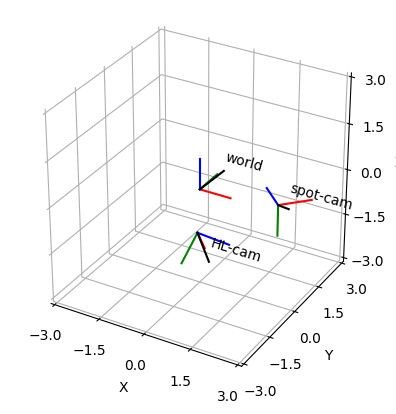

In [ ]:
tm = TransformManager()
# add transform follows order from -> to
tm.add_transform("spot-imu", "world", T_G_spot)
tm.add_transform("HL-imu", "world", T_G_HL)
tm.add_transform("HL-cam", "HL-imu", HL_T_imu_cam)
tm.add_transform("spot-cam", "spot-imu", spot_T_imu_cam)
tm.plot_frames_in("world", s=1, ax_s=3, whitelist=["world", "HL-cam", "spot-cam"])

/spot/imu sensor_msgs/msg/Imu
/Odometry nav_msgs/msg/Odometry
/spot/odometry nav_msgs/msg/Odometry
/Imu sensor_msgs/msg/Imu
/LFImages_rot sensor_msgs/msg/Image
/RRImages_rot sensor_msgs/msg/Image
/spot/rgb/image_rect_color sensor_msgs/msg/Image
/spot/downsampled_throttled_points2 sensor_msgs/msg/PointCloud2
sensor_msgs__msg__Image(header=std_msgs__msg__Header(stamp=builtin_interfaces__msg__Time(sec=444593659, nanosec=796522700, __msgtype__='builtin_interfaces/msg/Time'), frame_id='DepthMap', __msgtype__='std_msgs/msg/Header'), height=640, width=480, encoding='mono8', is_bigendian=0, step=480, data=array([18, 21, 18, ..., 36, 37, 35], dtype=uint8), __msgtype__='sensor_msgs/msg/Image')


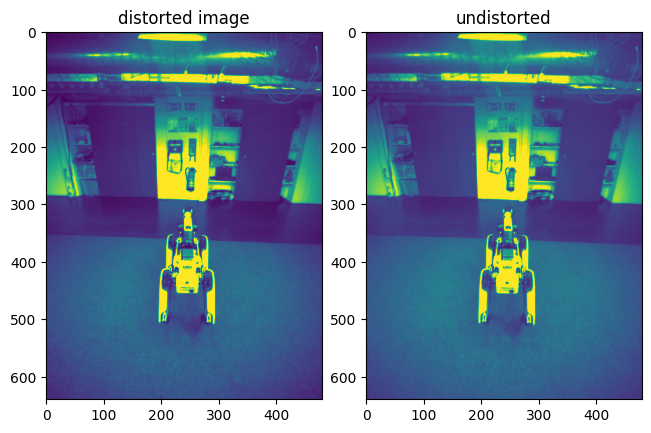

In [ ]:
# fig, ax = plt.subplots()


# This piece of code reads the bag file. Due to the break at the end it will only read the first image from the Hololens

with Reader(bag_file) as reader:
    
    # List all topics avaiable in bag
    for connection in reader.connections:
        print(connection.topic, connection.msgtype) 

    # idx = 0
    # read first frame. Display it
    for connection, timestamp, rawdata in reader.messages():
        if connection.topic == holo_camera_topic: #and timestamp==1679057419140768911:
            msg = deserialize_cdr(ros1_to_cdr(rawdata, connection.msgtype), connection.msgtype)
            print(msg)
            # print(type(msg.data))
            if mission_select != 4:
              image = msg.data.reshape(480,640)
              image = image.T[:, ::-1]
            else:
              image = msg.data.reshape(640,480)
            
            undistorted_image = cv2.undistort(image, K, D)
            # print(f"Saving frame {idx:04}")
            # cv2.imwrite(f'drive/My Drive/outputs/{idx:04}.png', undistorted_image)
            # idx += 1

            f, ax = plt.subplots(1, 2, layout='constrained') 
            ax[0].set(title="distorted image")
            ax[0].imshow(image)

            ax[1].set(title="undistorted")
            ax[1].imshow(undistorted_image)
            break

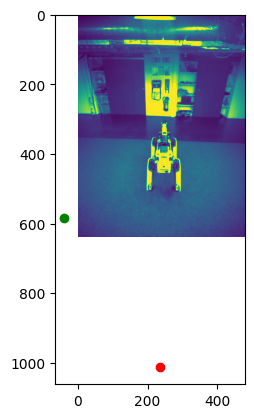

In [ ]:
def get_projected_point(pq_spot, pq_HL, p=[0., 0., 0.]):
    T_G_spot = pytr.transform_from_pq(pq_spot)
    T_G_HL = pytr.transform_from_pq(pq_HL)

    T_HL_spot = invert_transform(HL_T_imu_cam) @ invert_transform(T_G_HL) @ (T_G_spot) @ (spot_T_imu_cam)
    T_HL_spot = invert_transform(T_G_HL) @ (T_G_spot) @ (spot_T_imu_cam)
    p_in_HL_frame = T_HL_spot @ np.array([p[0], p[1], p[2], 1.])[:, None]
    assert p_in_HL_frame[3] == 1.

    point2d = K @ Id @ p_in_HL_frame

    # point2d = point2d/point2d[2]
    # assert point2d[2] == 1.

    # point2d = K @ p_in_HL_frame[:3]

    
    return point2d

fig, ax = plt.subplots()
ax.imshow(image)
point2d = get_projected_point(pq1,pq2)
ax.scatter([point2d[0]], [point2d[1]], color='red')
point2d = get_projected_point(pq1,pq2, p=[0, 0, -1])
ax.scatter([point2d[0]], [point2d[1]], color='green')
#ax.scatter(float(point2d[0]/point2d[2]), float(point2d[1]/point2d[2]), color='red')
plt.show()

In [ ]:
point2d

matrix([[-40.33677886],
        [583.83664662],
        [ -0.67372537]])

In [ ]:
# Reading vertex_poses_velocities_biases.csv into pandas dataframe

df = pd.read_csv(csv_file, delimiter=', ')  
print(df)
df = df.astype({'mission-id': str})
# spot_mission_id = "96444661842355170e00000000000000"
# holo_mission_id = "5a298db8012a55170d00000000000000"

holo_mission = df[df['mission-id'].astype('string') == holo_mission_id]
spot_mission = df[df['mission-id'].astype('string') == spot_mission_id]

spot_mission = spot_mission.reset_index()
holo_mission = holo_mission.reset_index()



<ipython-input-11-5e2e82ed8171>:3: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  df = pd.read_csv(csv_file, delimiter=', ')


        # timestamp [ns]                         vertex-id  \
0    1685022057181279809  e7f93c9ba3666217fc00000000000000   
1    1685022057514620953  1c96dfa7a36662170c01000000000000   
2    1685022057881649375  5907dfa9a36662171201000000000000   
3    1685022058215069402  3d7b97aba36662171801000000000000   
4    1685022058582089159  6c4532ada36662172201000000000000   
..                   ...                               ...   
677   444593942618703510  9d617d93ca6662171a0a020000000000   
678   444593943541765010  0e12b9c7ca6662173c0a020000000000   
679   444593944432877410  75ac7c01cb6662175e0a020000000000   
680   444593947865480910  58b46fcccb666217df0a020000000000   
681   444593948129103810  6f05a1fecb6662179b23020000000000   

                           mission-id  p_G_Ix [m]  p_G_Iy [m]  p_G_Iz [m]  \
0    d76cc50da26662170d00000000000000    0.212719   -2.379056    0.317325   
1    d76cc50da26662170d00000000000000    0.210980   -2.378007    0.315067   
2    d76cc50da26662170d0

In [ ]:
holo_mission

,index,# timestamp [ns],vertex-id,mission-id,p_G_Ix [m],p_G_Iy [m],p_G_Iz [m],q_G_Iw,q_G_Ix,q_G_Iy,...,q_M_Iz,v_Mx [m/s],v_My [m/s],v_Mz [m/s],bgx [rad/s],bgy [rad/s],bgz [rad/s],bax [m/s^2],bay [m/s^2],baz [m/s^2]
0,532,444593759392062010,4b6eddf89f6662172d00000000000000,c42fbb919f6662170f00000000000000,-2.136781,0.775733,0.178683,-0.183841,0.743412,0.083798,...,0.261614,0.111583,-0.328040,0.148954,-0.004213,-0.006041,-0.006038,0.116037,0.171722,-0.179525
1,533,444593765109978410,829f463ea1666217fa00000000000000,c42fbb919f6662170f00000000000000,-1.975955,0.651629,0.155242,-0.194743,0.740894,0.072816,...,0.272562,-0.309353,0.041695,-0.024629,0.004805,0.003237,-0.004163,0.082481,0.181917,-0.178038
2,534,444593765638456010,20e38561a16662170e01000000000000,c42fbb919f6662170f00000000000000,-1.779025,0.562694,0.144572,-0.203890,0.742877,0.068423,...,0.281055,-0.434120,0.122810,0.004467,0.007054,0.000292,-0.004087,0.077440,0.184220,-0.178865
3,535,444593766300110910,afc53687a16662172701000000000000,c42fbb919f6662170f00000000000000,-1.592946,0.400822,0.132328,-0.222062,0.730050,0.114970,...,0.299342,-0.291637,0.227408,0.024322,0.018741,0.004275,-0.013365,0.085854,0.177874,-0.183533
4,536,444593766960956510,bb74abb2a16662174001000000000000,c42fbb919f6662170f00000000000000,-1.420114,0.256740,0.116345,-0.206008,0.736696,0.084736,...,0.283720,-0.379332,0.032241,-0.022992,0.009606,-0.006325,-0.008372,0.060545,0.162129,-0.169314
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145,677,444593942618703510,9d617d93ca6662171a0a020000000000,c42fbb919f6662170f00000000000000,-2.791089,-0.013339,-0.011701,-0.199315,0.732987,-0.066475,...,0.278135,0.008403,0.024042,0.012776,0.017878,0.001555,0.002645,0.076695,0.086745,0.213610
146,678,444593943541765010,0e12b9c7ca6662173c0a020000000000,c42fbb919f6662170f00000000000000,-2.757007,-0.021365,-0.028807,-0.281486,0.728768,-0.069750,...,0.356358,-0.055237,-0.043288,0.007751,0.023156,-0.012882,0.004104,0.123027,0.099522,0.219186
147,679,444593944432877410,75ac7c01cb6662175e0a020000000000,c42fbb919f6662170f00000000000000,-2.603919,0.120215,-0.030880,-0.260526,0.713858,-0.117786,...,0.337914,-0.128555,-0.331847,-0.028724,0.010596,-0.006868,-0.004674,0.124673,0.103783,0.221340
148,680,444593947865480910,58b46fcccb666217df0a020000000000,c42fbb919f6662170f00000000000000,-2.503298,0.182158,-0.009098,-0.238344,0.729235,-0.071176,...,0.315678,0.004514,0.013658,0.005218,0.001874,0.007803,-0.008205,0.150981,0.104854,0.214431


In [ ]:

timestamps_csv_spot = spot_mission['# timestamp [ns]']
timestamps_csv_HL = holo_mission['# timestamp [ns]']

# plt.scatter(timestamps_csv_spot, 1 * np.ones_like(timestamps_csv_spot))
# plt.scatter(timestamps_csv_HL, 2 * np.ones_like(timestamps_csv_HL))
# plt.show()

timestamps_cam_spot = []
timestamps_cam_HL = []
timestamps_bag_spot = []
timestamps_bag_HL = []
with Reader(bag_file) as reader:

    for connection, timestamp, rawdata in reader.messages():
        if connection.topic == holo_camera_topic:
            timestamps_bag_HL.append(timestamp)
            msg = deserialize_cdr(ros1_to_cdr(rawdata, connection.msgtype), connection.msgtype)
            stamp = msg.header.stamp
            timestamps_cam_HL.append(int(stamp.sec * 1e9 + stamp.nanosec))
        if connection.topic == spot_camera_topic:
            timestamps_bag_spot.append(timestamp)
            msg = deserialize_cdr(ros1_to_cdr(rawdata, connection.msgtype), connection.msgtype)
            stamp = msg.header.stamp
            timestamps_cam_spot.append(int(stamp.sec * 1e9 + stamp.nanosec))

In [ ]:
timestamps_cam_HL[0]

444593283602612672

In [ ]:
timestamps_bag_HL[0]

1685021571575995487

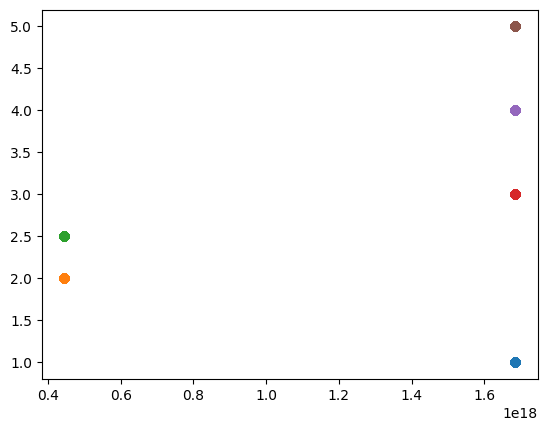

In [ ]:
timestamps_csv_HL[0]
plt.scatter(timestamps_bag_HL, 1 * np.ones_like(timestamps_bag_HL))
plt.scatter(timestamps_csv_HL, 2 * np.ones_like(timestamps_csv_HL))
plt.scatter(timestamps_cam_HL, 2.5 * np.ones_like(timestamps_cam_HL)) # --
plt.scatter(timestamps_bag_spot, 3 * np.ones_like(timestamps_bag_spot))
plt.scatter(timestamps_csv_spot, 4 * np.ones_like(timestamps_csv_spot)) # --
plt.scatter(timestamps_cam_spot, 5 * np.ones_like(timestamps_cam_spot))
plt.show()

In [ ]:
print(f'length spot csv: {(timestamps_csv_spot.tolist()[-1] - timestamps_csv_spot[0]) / 1000000}')
print(f'length spot bag: {(timestamps_bag_spot[-1] - timestamps_bag_spot[0]) / 1000000}')
print(f'length spot cam: {(timestamps_cam_spot[-1] - timestamps_cam_spot[0]) / 1000000}')
print(f'length holo csv: {(timestamps_csv_HL.tolist()[-1] - timestamps_csv_HL[0]) / 1000000}')
print(f'length holo bag: {(timestamps_bag_HL[-1] - timestamps_bag_HL[0]) / 1000000}')
print(f'length holo cam: {(timestamps_cam_HL[-1] - timestamps_cam_HL[0]) / 1000000}')

length spot csv: 179202.835574
length spot bag: 81642.727906
length spot cam: 81498.323456
length holo csv: 188737.0418
length holo bag: 82096.704169
length holo cam: 82132.312448


In [ ]:
# Visualizing position of cameras over time

selected_spot_timestamp = timestamps_csv_spot[0]
selected_holo_timestamp = timestamps_csv_HL[0]


#-------------------------------
selected_spot = (spot_mission.iloc[(spot_mission['# timestamp [ns]'].astype('int')-int(selected_spot_timestamp)).abs().argsort()[0]])
selected_spot = pd.DataFrame([selected_spot])
selected_spot['mission-id']="spot mission"

selected_holo = holo_mission.iloc[(holo_mission['# timestamp [ns]'].astype('int')-int(selected_holo_timestamp)).abs().argsort()[0]]
selected_holo = pd.DataFrame([selected_holo])
selected_holo['mission-id']="holo mission"


pq_HL = np.array([
    selected_holo["p_G_Ix [m]"], selected_holo["p_G_Iy [m]"], selected_holo["p_G_Iz [m]"], 
    selected_holo["q_G_Iw"], selected_holo["q_G_Ix"], selected_holo["q_G_Iy"], selected_holo["q_G_Iz"]])
pq_spot = np.array([
    selected_spot["p_G_Ix [m]"], selected_spot["p_G_Iy [m]"], selected_spot["p_G_Iz [m]"], 
    selected_spot["q_G_Iw"], selected_spot["q_G_Ix"], selected_spot["q_G_Iy"], selected_spot["q_G_Iz"]])

T_G_selected_spot = pytr.transform_from_pq(pq_spot[:,0])
T_G_selected_HL = pytr.transform_from_pq(pq_HL[:,0])


# https://plotly.com/python/cone-plot/ Use cones to show which way cameras are looking
# fig = px.scatter_3d(pd.concat([df, selected_spot, selected_holo]), x='p_G_Ix [m]', y='p_G_Iy [m]', z='p_G_Iz [m]', size = '# timestamp [ns]', color='mission-id')
# fig = px.line_3d(pd.concat([df, selected_spot, selected_holo]), x='p_G_Ix [m]', y='p_G_Iy [m]', z='p_G_Iz [m]', color='mission-id')
# fig.show()

#---------------------------- We can either use one of the two above plotting functions, or the ones defined below

spot_line = go.Scatter3d(
    x = spot_mission['p_G_Ix [m]'],
    y = spot_mission['p_G_Iy [m]'],
    z = spot_mission['p_G_Iz [m]'],
    mode='lines',
    name='spot Mission Line'
)
holo_line = go.Scatter3d(
    x = holo_mission['p_G_Ix [m]'],
    y = holo_mission['p_G_Iy [m]'],
    z = holo_mission['p_G_Iz [m]'],
    mode='lines',
    name='HoloLens Mission Line'
)

# Create a trace for the scatter plot
selected_points = pd.concat([selected_spot, selected_holo])
trace_scatter = go.Scatter3d(
    x = selected_points['p_G_Ix [m]'],
    y = selected_points['p_G_Iy [m]'],
    z = selected_points['p_G_Iz [m]'],
    mode='markers',
    name='Selected Point'
)

# selected_point_transformation * [1,0,0,1].T - selected_point_position -> camera orientation vector 
HL_orientation = ((T_G_selected_HL @ np.array([1, 0, 0, 1.]).T))[:3] - (pq_HL[:3].T)
spot_orientation = ((T_G_selected_spot @ np.array([1, 0, 0, 1.]).T))[:3] - (pq_spot[:3].T)


view_cone = go.Cone(
    x=selected_points['p_G_Ix [m]'],
    y=selected_points['p_G_Iy [m]'],
    z=selected_points['p_G_Iz [m]'],
    u=[spot_orientation[0][0], HL_orientation[0][0]],
    v=[spot_orientation[0][1], HL_orientation[0][0]],
    w=[spot_orientation[0][2], HL_orientation[0][0]],
    sizemode="absolute",
    sizeref=2,
    anchor="tip"
)
#TODO get position/rotation, display the   |/_   for the selected points 

# Create the data array with both traces
data = [spot_line, holo_line, trace_scatter, view_cone]

# Create the figure
fig = go.Figure(data=data)

fig.show()


In [ ]:
assert False
#This cell intentionally causes an error, so that it blocks progress when running "Execute all" and thus avoids starting the next block, which takes a very long time

AssertionError: ignored

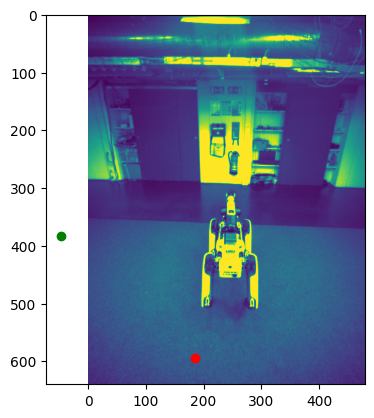

In [ ]:
def get_projected_point(pq_spot, pq_HL, p=[0., 0., 0.]):
    T_G_spot = pytr.transform_from_pq(pq_spot)
    T_G_HL = pytr.transform_from_pq(pq_HL)

    T_HL_spot = invert_transform(HL_T_imu_cam) @ invert_transform(T_G_HL) @ (T_G_spot) @ (spot_T_imu_cam)
    p_in_HL_frame = T_HL_spot @ np.array([p[0], p[1], p[2], 1.])[:, None]
    assert p_in_HL_frame[3] == 1.

    point2d = K @ Id @ p_in_HL_frame

    # point2d = point2d/point2d[2]
    # assert point2d[2] == 1.

    # point2d = K @ p_in_HL_frame[:3]

    
    return point2d

closest_match_spot = spot_mission.iloc[(spot_mission['# timestamp [ns]'].astype('int')-int(0)).abs().argsort()[0]]
# recording timestamp of HL is aligned with csv timestamp of HL
closest_match_holo = holo_mission.iloc[(holo_mission['# timestamp [ns]'].astype('int')-int(0)).abs().argsort()[0]]

pq_HL = np.array([
    closest_match_holo["p_G_Ix [m]"], closest_match_holo["p_G_Iy [m]"], closest_match_holo["p_G_Iz [m]"], 
    closest_match_holo["q_G_Iw"], closest_match_holo["q_G_Ix"], closest_match_holo["q_G_Iy"], closest_match_holo["q_G_Iz"]])

pq_spot = np.array([
    closest_match_spot["p_G_Ix [m]"], closest_match_spot["p_G_Iy [m]"], closest_match_spot["p_G_Iz [m]"], 
    closest_match_spot["q_G_Iw"], closest_match_spot["q_G_Ix"], closest_match_spot["q_G_Iy"], closest_match_spot["q_G_Iz"]])
fig, ax = plt.subplots()
ax.imshow(image)
point2d = get_projected_point(pq_spot,pq_HL)
ax.scatter([point2d[0]], [point2d[1]], color='red')
point2d = get_projected_point(pq_spot,pq_HL, p=[0, 0, -1])
ax.scatter([point2d[0]], [point2d[1]], color='green')
#ax.scatter(float(point2d[0]/point2d[2]), float(point2d[1]/point2d[2]), color='red')
plt.show()

In [ ]:
# Parsing entire bag.

# Finding out how many Hololens camera frames are contained within the bag 
totalFrames = 0
with Reader(bag_file) as reader:
    for connection, timestamp, rawdata in reader.messages():
        if connection.topic == holo_camera_topic:
            totalFrames+=1
print(f"{totalFrames} image frames")

holo_mission_start_time = (holo_mission.loc[0])['# timestamp [ns]'].astype('int')
spot_mission_start_time = (spot_mission.loc[0])['# timestamp [ns]'].astype('int')


with Reader(bag_file) as reader:
    
    for connection in reader.connections:
        print(connection.topic, connection.msgtype)
    
    i = 0

    #  keep these lists to draw a line between each position
    found_points_x = []
    found_points_y = []

    for connection, timestamp, rawdata in reader.messages():
        if connection.topic == holo_camera_topic:
            msg = deserialize_cdr(ros1_to_cdr(rawdata, connection.msgtype), connection.msgtype)

            stamp = msg.header.stamp
            timestamp_cam_HL = int(stamp.sec * 1e9 + stamp.nanosec)
            
            if mission_select != 4:
              image = msg.data.reshape(480,640)
              image = image.T[:, ::-1]
            else:
              image = msg.data.reshape(640,480)
            

            # camera timestamp of HL is aligned with csv timestamp of spot
            #WARNING missions seem to have inconsistent timestamps?!
            if mission_select==1:
              closest_match_spot = spot_mission.iloc[(spot_mission['# timestamp [ns]'].astype('int')-int(timestamp_cam_HL)).abs().argsort()[0]]
            elif mission_select==3 or mission_select==4 or mission_select == 5:
              #print("WARNING inconsistem timestamp offsets across missions")
              closest_match_spot = spot_mission.iloc[(spot_mission['# timestamp [ns]'].astype('int')-int(timestamp)).abs().argsort()[0]]
            # recording timestamp of HL is aligned with csv timestamp of HL
            closest_match_holo = holo_mission.iloc[(holo_mission['# timestamp [ns]'].astype('int')-int(timestamp)).abs().argsort()[0]]

            pq_HL = np.array([
                closest_match_holo["p_G_Ix [m]"], closest_match_holo["p_G_Iy [m]"], closest_match_holo["p_G_Iz [m]"], 
                closest_match_holo["q_G_Iw"], closest_match_holo["q_G_Ix"], closest_match_holo["q_G_Iy"], closest_match_holo["q_G_Iz"]])
            
            pq_spot = np.array([
                closest_match_spot["p_G_Ix [m]"], closest_match_spot["p_G_Iy [m]"], closest_match_spot["p_G_Iz [m]"], 
                closest_match_spot["q_G_Iw"], closest_match_spot["q_G_Ix"], closest_match_spot["q_G_Iy"], closest_match_spot["q_G_Iz"]])
            
            # get at what fraction in spot_mission we are. Use it to get appropriate postion in hololens_mission
            #4. draw point on image
            point2d = get_projected_point(pq_spot,pq_HL)
            # print(point2d, point2d.shape)
            x = point2d[0]
            y = point2d[1]
            if x<1500 and x>-150 and y<1500 and y>-150: # Here I check if the point falls too far outside frame. (This can occur when spot is outside camera, f.ex: 90° left of hololen )
                fig, ax = plt.subplots() # FIXME: This was added here so for each frame we see a new image
                ax.imshow(image)
                found_points_x.append(x[0, 0])
                found_points_y.append(y[0, 0])
                ax.plot(found_points_x,found_points_y)
                ax.scatter([x], [y], color='red')
                point2d = get_projected_point(pq_spot,pq_HL, p=[0, 0, -1])
                ax.scatter([point2d[0]], [point2d[1]], color='green')
                #5. save image
                # TDOO see how colab handles saving images
                #fig.savefig(f'drive/My Drive/bags/output/match_{timestamp}.png')
                plt.show()
            else:
                print(f"Point discarded ({x},{y})")


            #print(f"Fraction: {fraction} | spot index {int(fraction*spot_mission.shape[0])} | holo index {int(fraction*hololens_mission.shape[0])}")